# Gas Power Plant Update
To update the quality of our old gas power plant data, we find four latest datasources:

 - [List of conventional power plants in Germany and European countries ](https://data.open-power-system-data.org/conventional_power_plants/) (last update: 2020)

 - [JRC Open Power Plants Database (JRC-PPDB-OPEN) (from EU Joint Research Centre)](https://zenodo.org/record/3574566#.YXAiQi-22Rs) (last update: 2019)
**warning**: part of JRC data used data of [powerplantmatching repository]( https://github.com/FRESNA/powerplantmatching)

 -  [Global Powerplant Database](https://datasets.wri.org/dataset/globalpowerplantdatabase) (last update: Sep-2021)

 - **[ENTSOE Database](https://transparency.entsoe.eu)** (real time) **(we finally choose this one)**

 There are two way to visit this database:
		 

- **crawler** (this is the way I use)
- [**entsoe-py python package**](https://github.com/EnergieID/entsoe-py/blob/master/entsoe/mappings.py)
easy to use; well documented; also suitable to get other high time resolution data about transimssion grid

 In this updating we focus on attributes of power plants below:
 

 - **Installed Capacity**
 - **Commission date** 
 - **Location (city name)**

# Country Level Natural Gas Power Plant Capacity Changes

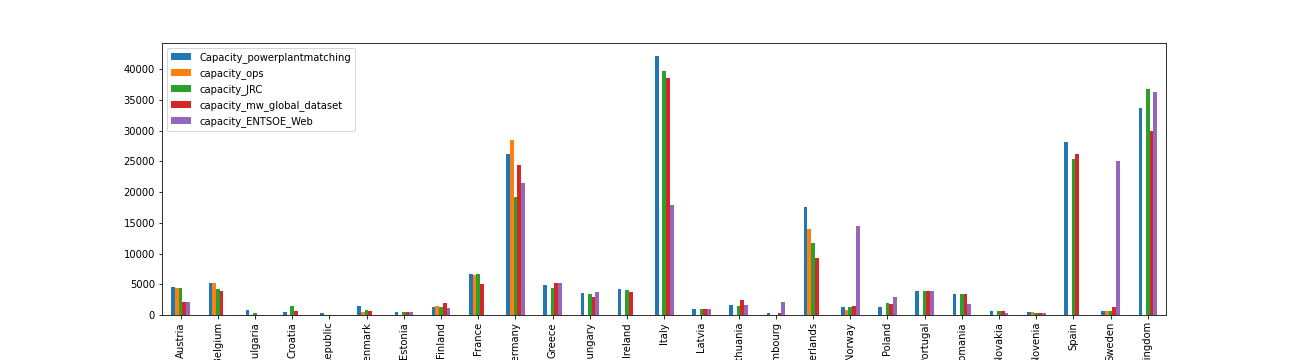

In [1]:
from IPython.display import Image
Image('graphs/capacity per country per database.png', width=1500)

# Country Level Natural Gas Power Plant Capacity Difference
(new capacity - powerplantmatching capacity)/(powerplantmatching capacity)

limit difference percentage to [-100%, 100%] 

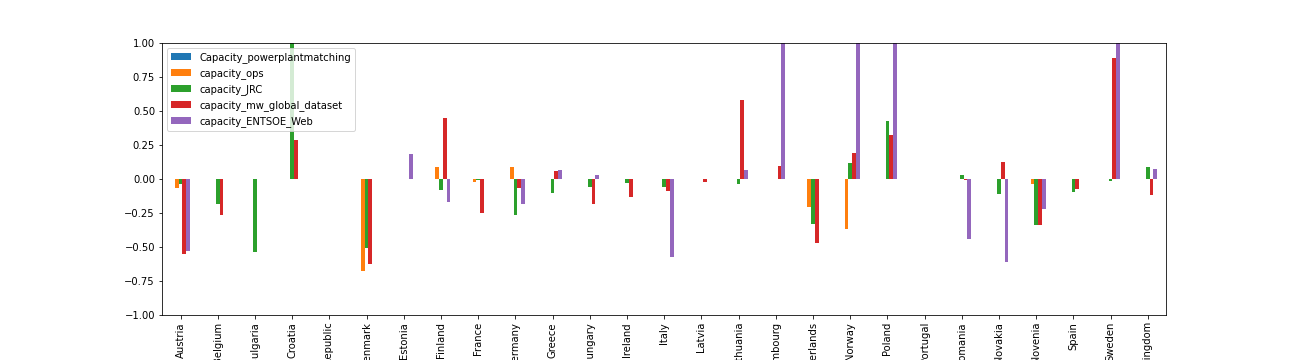

In [2]:
from IPython.display import Image
Image('graphs/relative_difference_limited.png', width=1500)

In [3]:
# python 3.9 also need 'lxml'
from tqdm.notebook import tqdm
from entsoe import EntsoePandasClient, EntsoeRawClient  # latest
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd  # 1.3.4
import pandas_bokeh  # 0.5.5
import pycountry  # 20.7.3
#from pandas_profiling import ProfileReport
pandas_bokeh.output_notebook()

Loading BokehJS ...

# JRC

In [4]:
# JRC
df = pd.read_csv('data/JRC_OPEN_UNITS.csv')
# only gas
df = df.loc[(df.type_g == 'Fossil Gas') & (
    df.status_g == 'COMMISSIONED'), :].reset_index(drop=True)
country_code_map = {}
for c in df.country.unique():
    country_code_map[c] = pycountry.countries.search_fuzzy(c)[0].name
df['country'] = df['country'].apply(lambda x: country_code_map[x])
# ProfileReport(df[['year_commissioned','year_decommissioned']])

# useless decommission year: the maximum is 2018, only have data of past

In [5]:
# each record is a generate unit, therefore we use capacity_g as our capacity
JRC_summary = df.groupby('country')['capacity_g'].sum().reset_index()
# capacity summary per country
JRC_summary['country'] = JRC_summary['country'].apply(
    lambda x: pycountry.countries.search_fuzzy(x)[0].name)

JRC_summary.columns = ['Country', 'capacity_JRC']
JRC_summary.set_index('Country', inplace=True)

# OPS

In [6]:
# OPS
ops = pd.read_csv(
    'https://data.open-power-system-data.org/conventional_power_plants/2020-10-01/conventional_power_plants_EU.csv')
# only gas
ops = ops.loc[ops.energy_source_level_2 ==
              'Natural gas', :].reset_index(drop=True)

country_code_map = {}
for c in ops.country.unique():
    country_code_map[c] = pycountry.countries.search_fuzzy(c)[0].name
ops['country'] = ops['country'].apply(lambda x: country_code_map[x])

In [7]:
# capacity summary per country
ops_summary = ops.groupby('country')['capacity'].sum().reset_index()

# use united country code format
ops_summary['country'] = ops_summary['country'].apply(
    lambda x: pycountry.countries.search_fuzzy(x)[0].name)
ops_summary.columns = ['country', 'capacity_ops']
ops_summary.set_index('country', inplace=True)

# csv file of powerplantmatching 

In [8]:
# our old data
old_gas = pd.read_csv(
    'https://raw.githubusercontent.com/FRESNA/powerplantmatching/master/powerplants.csv')
old_gas = old_gas.loc[old_gas['Fueltype'] ==
                      'Natural Gas', :].reset_index(drop=True)

In [9]:
old_gas_summary = old_gas.groupby('Country')['Capacity'].sum().reset_index()
old_gas_summary.set_index('Country', inplace=True)

# Global Powerplant Database

In [10]:
# https://datasets.wri.org/dataset/globalpowerplantdatabase
global_dataset = pd.read_csv(
    'data/global_power_plant_database_v_1_3/global_power_plant_database.csv', low_memory=False)
# only gas
global_dataset = global_dataset[global_dataset['primary_fuel'] == 'Gas'].reset_index(
    drop=True)

In [11]:
global_summary = global_dataset[global_dataset['primary_fuel'] == 'Gas'].groupby(
    'country')['capacity_mw'].sum().reset_index()

In [12]:
global_summary['country'] = global_summary['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name)
global_summary.columns = ['country', 'capacity_mw_global_dataset']
global_summary = global_summary.set_index('country')

# ENTSOE Website database

In [13]:
ENTSOE_Web = pd.read_csv('output/ENTSOE_Web_database_gas_powerplant.csv')

In [14]:
ENTSOE_Web_summary = ENTSOE_Web.groupby(
    'Country')['Capacity'].sum().reset_index()
ENTSOE_Web_summary.set_index('Country', inplace=True)
ENTSOE_Web_summary.rename(
    {'Capacity': 'capacity_ENTSOE_Web'}, axis=1, inplace=True)

# Comparison of all four database

In [15]:
summary = old_gas_summary.merge(
    ops_summary, left_index=True, right_index=True, how='left')
summary = summary.merge(JRC_summary, left_index=True,
                        right_index=True, how='left')
summary = summary.merge(global_summary, left_index=True,
                        right_index=True, how='left')
summary = summary.merge(
    ENTSOE_Web_summary, left_index=True, right_index=True, how='left')
summary.rename({'Capacity': 'Capacity_powerplantmatching'},
               axis=1, inplace=True)

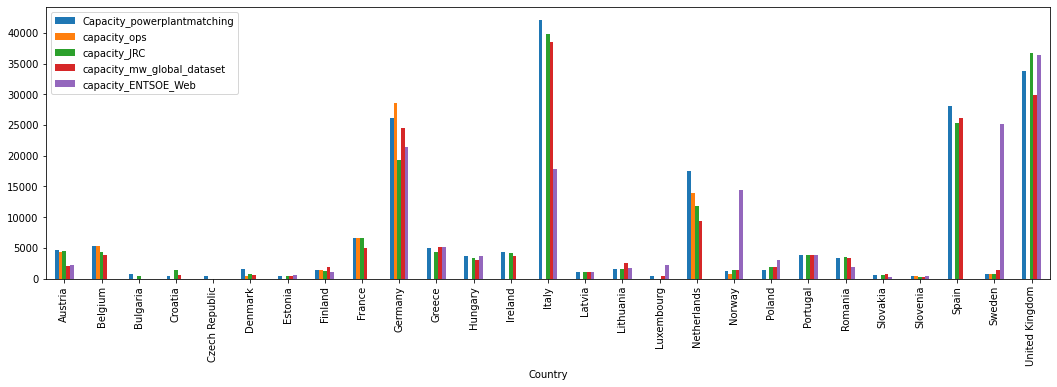

In [16]:
# y axis in normal space
plot = summary.plot.bar(figsize=(18, 5), logy=False)
plot.figure.savefig('capacity per country per database.png')

<AxesSubplot:xlabel='Country'>

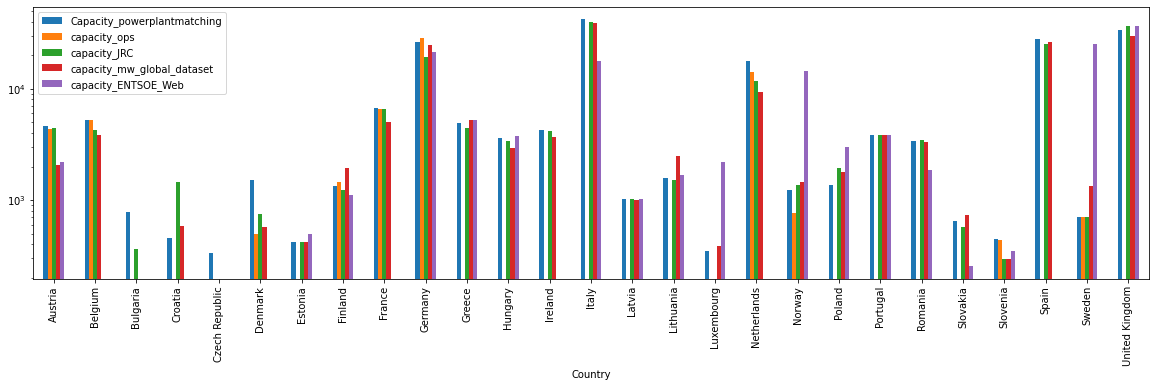

In [17]:
# y axis in log space
summary.plot.bar(figsize=(20,5),logy = True)

<AxesSubplot:xlabel='Country'>

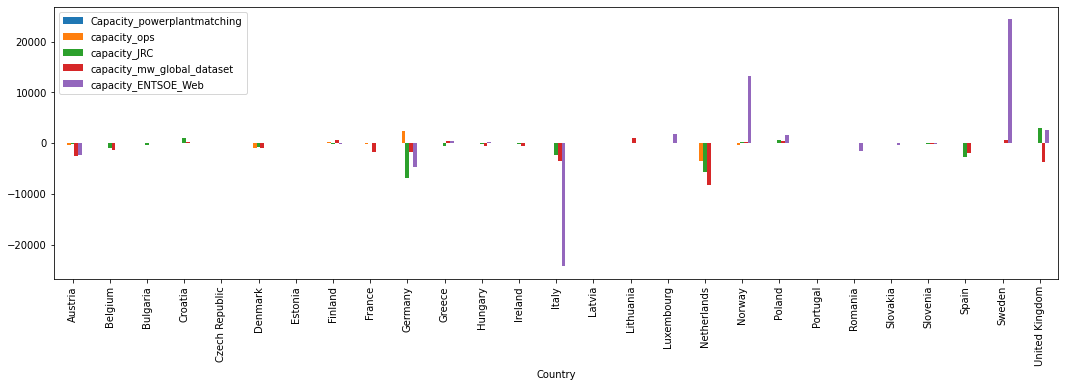

In [18]:
# difference between each new dataset and powerplantmatching csv file
summary_diff = summary.copy()
for column in summary_diff.columns:
    summary_diff[column] = (summary_diff[column] -
                            summary['Capacity_powerplantmatching'])
summary_diff.plot.bar(figsize=(18, 5), logy=False)

<AxesSubplot:xlabel='Country'>

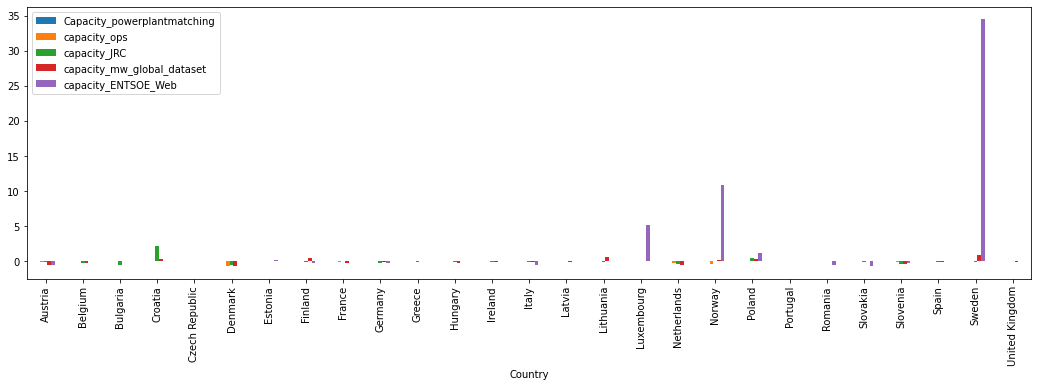

In [19]:
# relativ difference between each new dataset and powerplantmatching csv file
summary_diff = summary.copy()
for column in summary_diff.columns:
    summary_diff[column] = (
        summary_diff[column] - summary['Capacity_powerplantmatching'])/summary['Capacity_powerplantmatching']
summary_diff.plot.bar(figsize=(18, 5), logy=False)

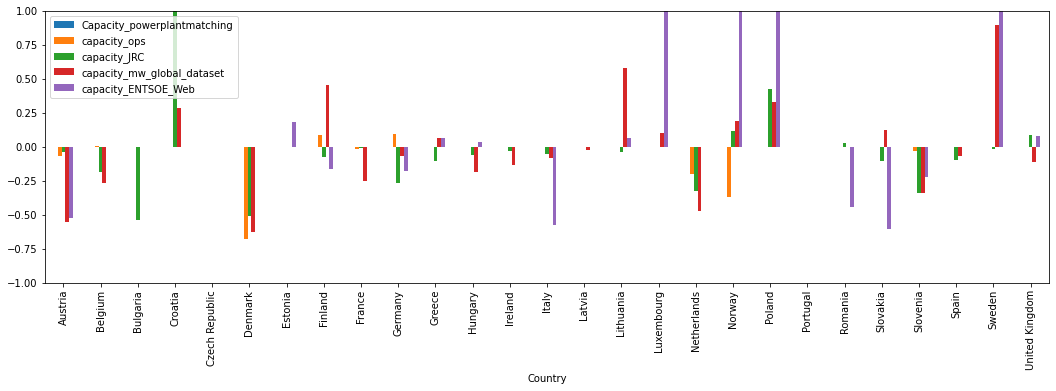

In [20]:
# relative difference between each new dataset and powerplantmatching csv file
# relative difference = (new capacity - powerplantmatching capacity)/powerplantmatching capacity
summary_diff = summary.copy()
for column in summary_diff.columns:
    summary_diff[column] = (
        summary_diff[column] - summary['Capacity_powerplantmatching'])/summary['Capacity_powerplantmatching']
plot = summary_diff.plot.bar(figsize=(18, 5), logy=False, ylim=(-1, 1))
plot.figure.savefig('relative_difference_limited.png')

# ENTSOE API table
you can apply an api token by writing a email to entsoe after registering an account on entsoe website

but feel free to use my api token: 7d479bbc-29b5-47cd-b7b3-6f0195368f38

In [21]:
# just an example
start = pd.Timestamp('20211001', tz='Europe/Brussels')
end = pd.Timestamp('20211002', tz='Europe/Brussels')
country_code = 'AT'  # Östereich

In [22]:
client = EntsoeRawClient(api_key='7d479bbc-29b5-47cd-b7b3-6f0195368f38')
raw_xml = client.query_installed_generation_capacity(
    country_code, start=start, end=end, psr_type='B04')
# this is similar to ENTSOE fuction in powerplantmatching repository

In [23]:
# it can directly return pandas dataframe when you use like this
# you can set filter by giving psr_type parameter a value, please check possible value in ENTSOE documentation
# you can find the documentation link in entsoe-py github readme.md
client = EntsoePandasClient(api_key='7d479bbc-29b5-47cd-b7b3-6f0195368f38')
df2 = client.query_installed_generation_capacity_per_unit(
    'AT', start=start, end=end, psr_type='B04')
df2.head(3)

,Bidding Zone,Installed Capacity [MW],Name,Production Type,Voltage Connection Level [kV]
14W-WGM-KW-----J,10YAT-APG------L,838,GDK-Mellach,Fossil Gas,380
14WLSG-MITTE---U,10YAT-APG------L,216.8,FHKW Linz Mitte,Fossil Gas,110
14W-KW-THE-EVN-7,10YAT-APG------L,485,Kraftwerk Theiß,Fossil Gas,110


# Crawler for getting data from website
entsoe webiste data has more content than entsoe api

# Interative Version
you can have a look in the website, how each step works

In [24]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

import os
from time import sleep

In [25]:
def find_all_by_country(alpha_2, keys):
    result = []
    for key in keys:
        if alpha_2 in key:
            result.append(key)
    return result

In [40]:
from entsoe.mappings import Area
country_dict = {}
for a in Area:
    country_dict[a.name] = a.code

# deal with United Kingdom unnormal country code
GB_1 = country_dict['GB']
country_dict['GB'] = '10Y1001A1001A92E'
country_dict['GB_1'] = GB_1


if not os.path.isdir('./test'):
    os.mkdir('./test')
abspath = os.path.abspath('./test')
number_of_file = len(os.listdir('./test'))

driver_path = ChromeDriverManager().install()

prefs = {}
# prefs["profile.default_content_settings.popups"]=0
prefs["download.default_directory"] = abspath

chrome_options = Options()
chrome_options.add_experimental_option("prefs", prefs)
# chrome_options.add_argument("--headless")

# open a web driver
driver = webdriver.Chrome(executable_path=driver_path, options=chrome_options)

[WDM] - 

INFO:WDM:

[WDM] - ====== WebDriver manager ======
INFO:WDM:====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
INFO:WDM:Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
INFO:WDM:Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/wenruizhou/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
INFO:WDM:Driver [/Users/wenruizhou/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
/var/folders/1p/yz3h9q_93dzcvnmt_lprhgdc0000gn/T/ipykernel_5890/450851234.py:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=driver_path, options=chrome_options)


In [41]:
# first time visit entsoe website
driver.get('https://transparency.entsoe.eu/')

In [42]:
# deal with agreement window of entsoe website
sleep(10)
try:
    driver.find_element(by = 'xpath', value = "//*[contains(text(), 'I Agree')]").click()
except:
    pass

In [43]:
# login
try:
    driver.find_element(by='id', value='login-dialog-visible').click()
except:
    pass
sleep(1)

name = driver.find_element(by='name', value='username')
password = driver.find_element(by='name', value='password')

# here I use my account, feel free to use them
name.send_keys('wenruizhou687@gmail.com')
password.send_keys('vujkih-nyqne2-Gaccot')

driver.find_element(by='name', value='login').click()

In [44]:
# function that use to visit a table
def query_website(country, bidzone, year, driver):
    query = 'https://transparency.entsoe.eu/generation/r2/installedCapacityPerProductionUnit/show?name=&defaultValue=true&viewType=TABLE&areaType=BZN&atch=false&dateTime.dateTime=01.01.{year}+00:00|UTC|YEAR&area.values=CTY|{country}!BZN|{bidzone}&productionType.values=B04'
    query = query.format(country=country, bidzone=bidzone, year=year)
    driver.get(query)

In [45]:
# visit table of country: 'HU' bidzone 'HU'
query_website(country_dict['HU'], country_dict['HU'], year=2021, driver=driver)

In [46]:
# get full country name
def get_full_country_name(driver, max_try_num=5):
    import re

    count = 0
    current = 0
    name_mapping = {}
    while count < max_try_num:
        try:
            c = driver.find_elements(
                by='xpath', value='//label[@for="{}"]'.format(current))
            c = c[1].text
            short = c.split('(')[-1]
            short = short.strip()[:-1]

            full = c.split('(')[0]
            full = re.sub(r'[^a-zA-Z ]', '', full)
            full = pycountry.countries.search_fuzzy(full)[0].name
            # remove ','
            #full = full.split(',')[0].strip()
            name_mapping[short] = full
            current += 1
        except:
            current += 1
            count += 1

    # deal with united kingdom, it has two alpha2 code: GB and UK
    name_mapping['GB'] = name_mapping['UK']

    return name_mapping

In [47]:
name_mapping = get_full_country_name(driver)

In [34]:
# download table in csv form, and save it in entsoe_tables folder under current pwd
x = len(os.listdir('./test'))
driver.find_element_by_id('dv-export-data').click()
while x == len(os.listdir('./test')):
    try:
        driver.find_element_by_xpath('//a[@exporttype="CSV"]').click()
    except:
        continue

/var/folders/1p/yz3h9q_93dzcvnmt_lprhgdc0000gn/T/ipykernel_5890/3840942831.py:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id('dv-export-data').click()
/var/folders/1p/yz3h9q_93dzcvnmt_lprhgdc0000gn/T/ipykernel_5890/3840942831.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//a[@exporttype="CSV"]').click()


In [48]:
#close web driver
driver.close()

# Fuction version
in fuction version, we don't need to open a website window
it can run in background

In [36]:
from tqdm.notebook import tqdm
import os
from pathlib import Path

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from entsoe.mappings import Area

country_dict = {}
for a in Area:
    country_dict[a.name] = a.code

# deal with United Kingdom unnormal country code
GB_1 = country_dict['GB']
country_dict['GB'] = '10Y1001A1001A92E'
country_dict['GB_1'] = GB_1


def find_all_by_country(alpha_2, keys):
    result = []
    for key in keys:
        if alpha_2 in key:
            result.append(key)
    return result

# get full country name


def get_full_country_name(driver, max_try_num=5):
    import re

    count = 0
    current = 0
    name_mapping = {}
    while count < max_try_num:
        try:
            c = driver.find_elements(
                by='xpath', value='//label[@for="{}"]'.format(current))
            c = c[1].text
            short = c.split('(')[-1]
            short = short.strip()[:-1]

            full = c.split('(')[0]
            full = re.sub(r'[^a-zA-Z ]', '', full)
            full = pycountry.countries.search_fuzzy(full)[0].name
            # remove ','
            #full = full.split(',')[0].strip()
            name_mapping[short] = full
            current += 1
        except:
            current += 1
            count += 1
            
    name_mapping['GB'] = name_mapping['UK']
    return name_mapping


def query_website(country, bidzone, year, driver):
    query = 'https://transparency.entsoe.eu/generation/r2/installedCapacityPerProductionUnit/show?name=&defaultValue=true&viewType=TABLE&areaType=BZN&atch=false&dateTime.dateTime=01.01.{year}+00:00|UTC|YEAR&area.values=CTY|{country}!BZN|{bidzone}&productionType.values=B04'
    query = query.format(country=country, bidzone=bidzone, year=year)
    driver.get(query)


def get_gas_powerplant(country_dict, download_path='./entsoe_tables', headless=True,
                       normal_sleep_interval=5, download_sleep_interval=3):
    # name mapping
    name_mapping = None

    # init webdriver options
    if not os.path.isdir(download_path):
        os.mkdir(download_path)
    abspath = os.path.abspath(download_path)
    number_of_file = len(os.listdir(download_path))

    # init driver
    driver_path = ChromeDriverManager().install()
    chrome_options = Options()

    prefs = {}
    prefs["download.default_directory"] = abspath
    chrome_options.add_experimental_option("prefs", prefs)
    if headless:
        chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(
        executable_path=driver_path, options=chrome_options)

    # init entsoe website
    driver.get('https://transparency.entsoe.eu/')
    sleep(normal_sleep_interval)
    try:
        driver.find_element(
            by='xpath', value="//*[contains(text(), 'I Agree')]").click()
    except:
        pass

    # login
    try:
        driver.find_element(by='id', value='login-dialog-visible').click()
    except:
        pass
    sleep(2)
    # input username and password
    name = driver.find_element(by='name', value='username')
    name.send_keys('wenruizhou687@gmail.com')
    password = driver.find_element(by='name', value='password')
    password.send_keys('vujkih-nyqne2-Gaccot')
    # login
    driver.find_element(by='name', value='login').click()

    # start download
    # find country codes
    countries = [a for a in country_dict.keys() if '_' not in a]
    for country in tqdm(countries):
        bidzones = find_all_by_country(country, country_dict.keys())
        for bidzone in tqdm(bidzones, leave=False):
            # visit target website
            try:
                # query successful
                query_website(country_dict[country],
                              country_dict[bidzone], year=2021, driver=driver)
                sleep(normal_sleep_interval)
                # click download link and download
                driver.find_element(by='id', value='dv-export-data').click()
                # wait until download successful
                while number_of_file == len(os.listdir(download_path)):
                    try:
                        driver.find_element(
                            by='xpath', value='//a[@exporttype="CSV"]').click()
                    except:
                        continue
                    sleep(download_sleep_interval)
                number_of_file = len(os.listdir(download_path))

                # download finishing

                # rename downloaded file:
                new_file = sorted(Path(download_path).iterdir(),
                                  key=os.path.getmtime)[-1]
                # add country code and remove leer file:
                df = pd.read_csv(new_file)
                if len(df) > 0:
                    df['country'] = country
                    df.to_csv(
                        download_path+'/{}{}.csv'.format(country, bidzone), index=False)

                    # unitl here, the table certainly successfully download
                    # check if need to download country name mapping
                    if name_mapping == None:
                        name_mapping = get_full_country_name(driver)

                os.remove(new_file)

            except:
                # query fail
                continue
                # avoid being blocked by server
                sleep(normal_sleep_interval)

    driver.close()
    return name_mapping

In [37]:
name_mapping = get_gas_powerplant(
    country_dict, download_path='./test', headless=False)

[WDM] - 

INFO:WDM:

[WDM] - ====== WebDriver manager ======
INFO:WDM:====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
INFO:WDM:Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
INFO:WDM:Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/wenruizhou/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
INFO:WDM:Driver [/Users/wenruizhou/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
/var/folders/1p/yz3h9q_93dzcvnmt_lprhgdc0000gn/T/ipykernel_5890/4142878259.py:84: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## Further process download table
    - change country name to standard name of pycountry package 
    - change column names to powerplantmatching repository style

In [38]:
# a package that get latitude and longtitude from powerplant name (city name) + country
from geopy.geocoders import Nominatim
# example:
#geolocator = Nominatim(user_agent="testagain",)
#location = geolocator.geocode('New York, USA')
#print(location.latitude, location.longitude)

In [49]:
from geopy.geocoders import Nominatim
import numpy as np


def robust_geo_code(query):
    geolocator = Nominatim(user_agent="gaspowerplantupdate")
    return None
    try:
        tmp = geolocator.geocode(query)
    except:
        tmp = None
    return tmp


def add_geo_info(dataframe, name_mapping):
    dataframe['country'] = dataframe['country'].apply(
        lambda x: name_mapping[x])

    locations = (dataframe['Name'] + ',' +
                 dataframe['country']).apply(robust_geo_code)

    dataframe['lat'] = [(lambda x: x.latitude if x !=
                         None else np.nan)(i) for i in locations]
    dataframe['long'] = [(lambda x: x.longitude if x !=
                          None else np.nan)(i) for i in locations]
    return dataframe


entsoe_data = []
for file in tqdm(os.listdir('./test/')):
    entsoe_data.append(add_geo_info(pd.read_csv(
        './test/'+file), name_mapping=name_mapping))
entsoe_data = pd.concat(entsoe_data)
entsoe_data = entsoe_data.reset_index(drop=True)

  0%|          | 0/32 [00:00<?, ?it/s]

In [50]:
entsoe_data = entsoe_data.rename({'Production Type': 'Fueltype',
                                  'Current Installed Capacity [MW]': 'Capacity',
                                  'country': 'Country',
                                  'Commissioning Date': 'DateIn',
                                  'Decommissioning Date': 'DateRetrofit',
                                  }, axis=1)

entsoe_data['Fueltype'] = 'Natural Gas'

#entsoe_data.drop('Area / Date', axis = 1, inplace = True)

entsoe_data.to_csv(
    'output/ENTSOE_Web_database_gas_powerplant.csv', index=False)

In [52]:
entsoe_data.head()

,Area / Date,Fueltype,Code,Name,Intalled Capacity at the beginning of year [MW],Capacity,Location,Voltage Connection Level [kV],DateIn,DateRetrofit,Country,lat,long
0,BZN|PT / 01.01.2021 00:00 - 01.01.2022 00:00,Natural Gas,16WRIBATE------E,Ribatejo,1176.0,1176.0,ALENQUER,400,01.12.2014,NaN,Portugal,NaN,NaN
1,BZN|PT / 01.01.2021 00:00 - 01.01.2022 00:00,Natural Gas,16WRTG---------V,T.Outeiro C.C.,990.0,990.0,GONDOMAR,220,01.12.2014,NaN,Portugal,NaN,NaN
2,BZN|PT / 01.01.2021 00:00 - 01.01.2022 00:00,Natural Gas,16WPEGO--------O,Pego C.C.,837.0,837.0,ABRANTES,400,01.12.2014,NaN,Portugal,NaN,NaN
3,BZN|PT / 01.01.2021 00:00 - 01.01.2022 00:00,Natural Gas,16WLARES-------R,Lares,826.0,826.0,FIGUEIRA DA FOZ,400,01.12.2014,NaN,Portugal,NaN,NaN
4,BZN|RO / 01.01.2021 00:00 - 01.01.2022 00:00,Natural Gas,30W-CET-PETROM-L,TPP CCCC Petrom Brazi,832.0,832.0,internal,400,01.12.2014,NaN,Romania,NaN,NaN


# geoposition of powerplantmatching is not working

In [53]:
#!pip install powerplantmatching
from powerplantmatching.utils import fill_geoposition

In [55]:
fill_geoposition(entsoe_data)

INFO:powerplantmatching.core:Parse geopositions for missing lat/lon values


ConfigurationError: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to fix this error. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing